In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import os
import gensim.downloader as api
from gensim.models import KeyedVectors
from collections import Counter
from nltk.corpus import stopwords
import nltk
import time
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn 
import torch
import torch.optim as optim
from transformers import BertTokenizer, BertModel, BertForSequenceClassification, AdamW, BertConfig
from keras_preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

2023-01-31 20:12:23.242467: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
import torch
device = torch.device("mps")

In [5]:
if torch.backends.mps.is_available(): #sanity check for gpu
    device = torch.device("mps")
    x = torch.ones(1, device=device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [6]:
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_colwidth', None)

<b><h2>Preprocessing and dictionary</h2></b><br>
Both functions are from previous notebook.

In [7]:
start = time.time()
def cleaning_pipeline(df):
    e_stopwords = stopwords.words('english')
    train_list = df["text"].values.tolist()
    words_without_stopw = []
    for sentence in train_list:
        temp = []
        for word in sentence.lower().split():
            if word not in e_stopwords and  word.isalpha():
                temp.append(word)
        words_without_stopw.append(temp)
    ret_df = pd.DataFrame({"raw_words": words_without_stopw, "label": df.label.values})
    return ret_df

def get_boW(l_of_words,k=100):
    words = set()
    for i in l_of_words:
        counter = Counter(i).most_common(k)
        words.update([i[0] for i in counter])
    return words
#------------------------------------------------------------#
SPLITS = ['train', 'test', "validation"]
datasets = { }

#Load the train, validation, and test sets.
path = "nlp2022_23_data/thedeep.subset.{}.txt"
csv_header = ['idx', 'text', 'label']
for split in SPLITS:
        datasets[split] = {}
        datasets[split]['df'] = cleaning_pipeline(pd.read_csv(path.format(split), names = csv_header))

n_label = 12
words = get_boW(datasets["train"]["df"]["raw_words"].values)
end = time.time()
print(end - start)

1.902383804321289


<b><h2>Data batching </h2></b><br>
We set the `batch_size`= 64 and `max_doc_l`= 50.


In [6]:
class M(Dataset):
    
    def __init__(self, dataset, max_doc_l, BoW):
        super().__init__()
        self.dataset = dataset
        self.max_doc_l = max_doc_l
        self.BoW = list(BoW)  


    def __getitem__(self, item):
        ret_val = np.zeros( self.max_doc_l) * len(self.BoW)
        i = 0
        
        for word in  self.dataset["raw_words"][item]:
            if i >= max_doc_l:
                    break
            if word in self.BoW:
                ret_val[i] = self.BoW.index(word) 
                i += 1
            
        return torch.from_numpy(ret_val).type(torch.IntTensor) , self.dataset["label"][item]


    def __len__(self):
        return len(self.dataset)

In [7]:
batch_size = 64
max_doc_l = 50

#----------------------------

train_p = M(datasets["train"]["df"], max_doc_l = max_doc_l, BoW= words)
train_loader = DataLoader(train_p , batch_size=batch_size)
val_p = M(datasets["validation"]["df"], max_doc_l = max_doc_l, BoW= words)
val_loader = DataLoader(val_p , batch_size=batch_size)
test_p = M(datasets["test"]["df"], max_doc_l = max_doc_l, BoW= words)
test_loader = DataLoader(test_p , batch_size=batch_size)

<b><h2>Word embedding lookup</h2></b>
</br>
Similar to (`doc_class_wembedd.ipynb`), the Word2Vec pre-trained word embedding has been used to initialize the word embeddings of the lookup. The final embedding has dimensions 21690x300 (= n. of words in our BoW x lenght of each embedding per vector) 


In [8]:
start = time.time()
path = 'word_vectors2.kv'
if os.path.exists(path):
    if not os.path.exists('word2vec-google-news-300'):
        word_vectors = KeyedVectors.load(path)
else:
    #model = api.load("glove-twitter-25")
    model = api.load('word2vec-google-news-300')
    word_vectors = model.wv
    word_vectors.save(path)
end = time.time()
print(end-start)

26.59146523475647


In [9]:
dict_ = {}
dict_[0] = np.full(shape=(300,),fill_value=0)
words = list(words)

for i,word in enumerate(words[1::],1):
     try:
        embedd_w = word_vectors.get_vector(word)
        if min(embedd_w) < min_:
            min_ = min(embedd_w)
        if max(embedd_w) > max_:
            max_ = max(embedd_w)
        dict_[i] = embedd_w
    
     except:
        dict_[i] = np.random.uniform(-3, 3, 300)

dict_keys = np.fromiter(dict_.keys(), dtype=float)
dict_vals = np.array(list(dict_.values()))  

In [10]:
embedding = torch.nn.Embedding.from_pretrained(torch.FloatTensor(dict_vals))

**<h2>Model definition & forward function</h2>** <br>
We define the class `ClassificationAverageModel` as a PyTorch model. In the initialization procedure, the model takes as parameters `embedding`: the word embedding lookup, and `n_label`, in our case 11.<br>
the `forward` function transforms the batch input according to the document representation expressed by the formula:
<center><div>$\mathbf{e}_d = \frac{1}{|d|}\sum_{i=1}^{|d|}{\mathbf{e}_{v_i}}$</div></center>


In [11]:
n_label

12

The labels, given as integer have been converted into one-hot encoded tensor (in the `update` step hereunder), <br>e.g. label 3 will look like: <br>

In [12]:
l_tensor = np.diag(np.ones(n_label))
print(f"tensor label 3:\n", l_tensor[3])

tensor label 3:
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


**<h2>Loss Function, optimization and early stopping</h2>**

The training and evaluation of the model have been deployed sequentally, meaning that in every epoch the data has been first processed by the <b>`update`</b> function, where the model parameters gets updated step by step, and takes the following arguments:<br>
`dataloader`: the training set divided in batches.   <br> `model`: the ClassificationAverageModel which weights gets updated step by step. <br> `loss`: Cross entropy loss. <br> `optimizer`: Adam optimizer with a learning rate of <b>0.0001</b>.<br>
`l_tensor`: the initialized matrix of tensor labels.<br><br>
and then by the <b>`evaluate`</b> function, with arguments:<br>
`val_dataloader`: the validation set.<br>  `model`: the updated model of ClassificationAverageModel.<br><br>
The early stopping comes in action whether the <b>maximum number of epoch (=100)</b> has been reached, or in case the <b>accuracy</b> on the validation test has <b>not improved for 20 consecutive epochs</b>.<br>
A seed has been set for reproducibility.<br>Hereunder we report the accuracy on the validation test, the error on the training test and the processing time for every 10 epochs (in seconds).

In [13]:
class ClassificationAverageModel(torch.nn.Module):
    
    def __init__(self, embedding, n_label):
        
        super(ClassificationAverageModel, self).__init__()
        
        self.embedding = torch.nn.Embedding(num_embeddings = embedding.num_embeddings, embedding_dim = embedding.embedding_dim )
        self.embedding.weight = embedding.weight
        self.transformation = torch.nn.Linear(in_features = embedding.embedding_dim, out_features = n_label, bias=True)
        self.softmax = torch.nn.Softmax(dim=-1)
        
    
    def forward(self, x):
        
        e = self.embedding(x)
        e = torch.sum(e, dim=1)
        counter = torch.tensor(np.count_nonzero(e, axis=0))
        e = torch.div(e, counter)
        e = self.transformation(e)
        return self.softmax(e) #calculates probability distribution of 11 labels
    

In [14]:
#@torch.enable_grad()
def update(dataloader, model, loss, optimizer, l_tensor): 
    device = next(model.parameters()).device
    err = []
    model.train()
    

    for x,y in dataloader:
      
        x, y = x.to(device), y.to(device) #gpu


        optimizer.zero_grad()
        y_pred = model.forward(x)
        
        y_true = torch.tensor([l_tensor[i] for i in y])

        loss_ = loss(y_pred, y_true) 
        
      
        err.append(loss_)
        
        loss_.backward()
        
        optimizer.step() 
        
        
    return err, model
       

In [15]:
#@torch.no_grad()
def evaluate(val_dataloader, model):
    device = next(model.parameters()).device
    accuracy = []
    
    for x,y in val_dataloader:
        x, y = x.to(device), y.to(device) #gpu
        
        y_pred = model.forward(x)
        y_pred = torch.argmax(y_pred, dim=1)
        accuracy_ = torch.mean((y == y_pred).float())
        
        accuracy.append(accuracy_)
    
    return accuracy
        

In [16]:
torch.manual_seed(42)

model = ClassificationAverageModel(embedding, n_label =n_label)

lr = 0.001
#-----------------

loss = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
epochs = 101
best_mean = 0.0
last_accuracy = 0
stats = pd.DataFrame(columns=["epoch", "training_error", "validation_accuracy"])
early_stopping = 20 #fix value
early_stopping_counter = 20 #counts

#-----------------

start = time.time()
for epoch in range(epochs):
    
    train_err, model = update(train_loader, model, loss, optimizer, l_tensor)
    train_err = ([x.tolist() for x in train_err])
    train_err = np.mean(train_err)
    accuracy = evaluate(val_loader, model)
    accuracy = ([x.tolist() for x in accuracy])
    accuracy = np.mean(accuracy)
    
    if epoch % 10 == 0:
        end2 = time.time()
        print(f"epoch n: {epoch}  accuracy: {accuracy} training_error: {train_err} in {end2-start} seconds")
    
    stats.loc[len(stats)] = [epoch,train_err,accuracy]
    
    if accuracy > best_mean:
        best_mean = accuracy
        torch.save(model, "best_model.pkl")
    
    else: #early stopping
        if np.isclose(last_accuracy, accuracy):
            
            if early_stopping_counter == 0:
                break

            else:
                early_stopping_counter -= 1
        else:
            early_stopping_counter = early_stopping
                  
    
    last_accuracy = accuracy
    

end = time.time()  
print(end-start)
stats.to_csv("stats.csv", index= False)
   

epoch n: 0  accuracy: 0.5383638208959161 training_error: 2.3888460649681607 in 119.91950392723083 seconds
epoch n: 10  accuracy: 0.6355013556596709 training_error: 2.025200458912921 in 1329.2269458770752 seconds
epoch n: 20  accuracy: 0.648077575171866 training_error: 1.9818621258986624 in 2571.900545835495 seconds
epoch n: 30  accuracy: 0.6542598241712989 training_error: 1.958490492456726 in 3822.824604988098 seconds
epoch n: 40  accuracy: 0.6560806239523539 training_error: 1.9439387639802426 in 5078.915493011475 seconds
epoch n: 50  accuracy: 0.6588329949030062 training_error: 1.9332045359326933 in 6332.198069095612 seconds
epoch n: 60  accuracy: 0.6603573851469087 training_error: 1.924409633426738 in 7585.547318935394 seconds
epoch n: 70  accuracy: 0.6611195802688599 training_error: 1.9172570573586158 in 8839.050158977509 seconds
epoch n: 80  accuracy: 0.6599762875859331 training_error: 1.9111389619375305 in 10092.367640018463 seconds
epoch n: 90  accuracy: 0.6588329949030062 traini

**<h2>Test Set Evaluation </h2>**

In [17]:
best_model = torch.load('best_model.pkl')
accuracy = evaluate(test_loader, model)
accuracy_ = ([x.tolist() for x in accuracy])
accuracy = np.mean(accuracy_)
print(f"Test accuracy: {accuracy * 100} %")


Test accuracy: 67.85605404435134 %


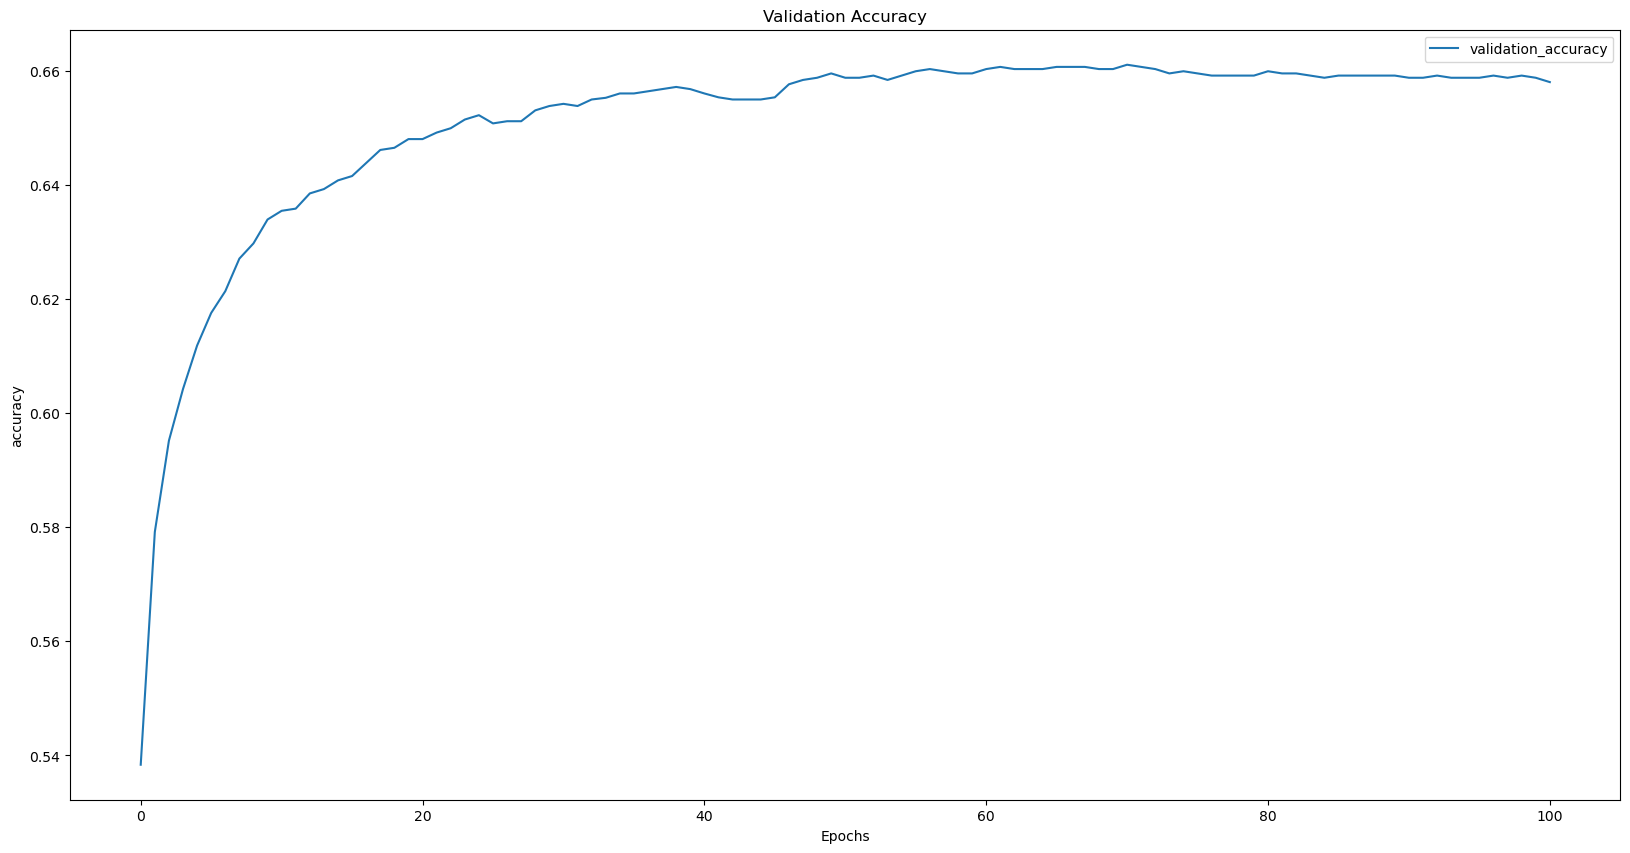

In [11]:
plt.rcParams['figure.figsize'] = [20, 10]
df = pd.read_csv('stats.csv')
df[['epoch', 'validation_accuracy']].plot(
    x='epoch',
    xlabel='Epochs',
    ylabel='accuracy',
    title='Validation Accuracy'
)
_=plt.show()

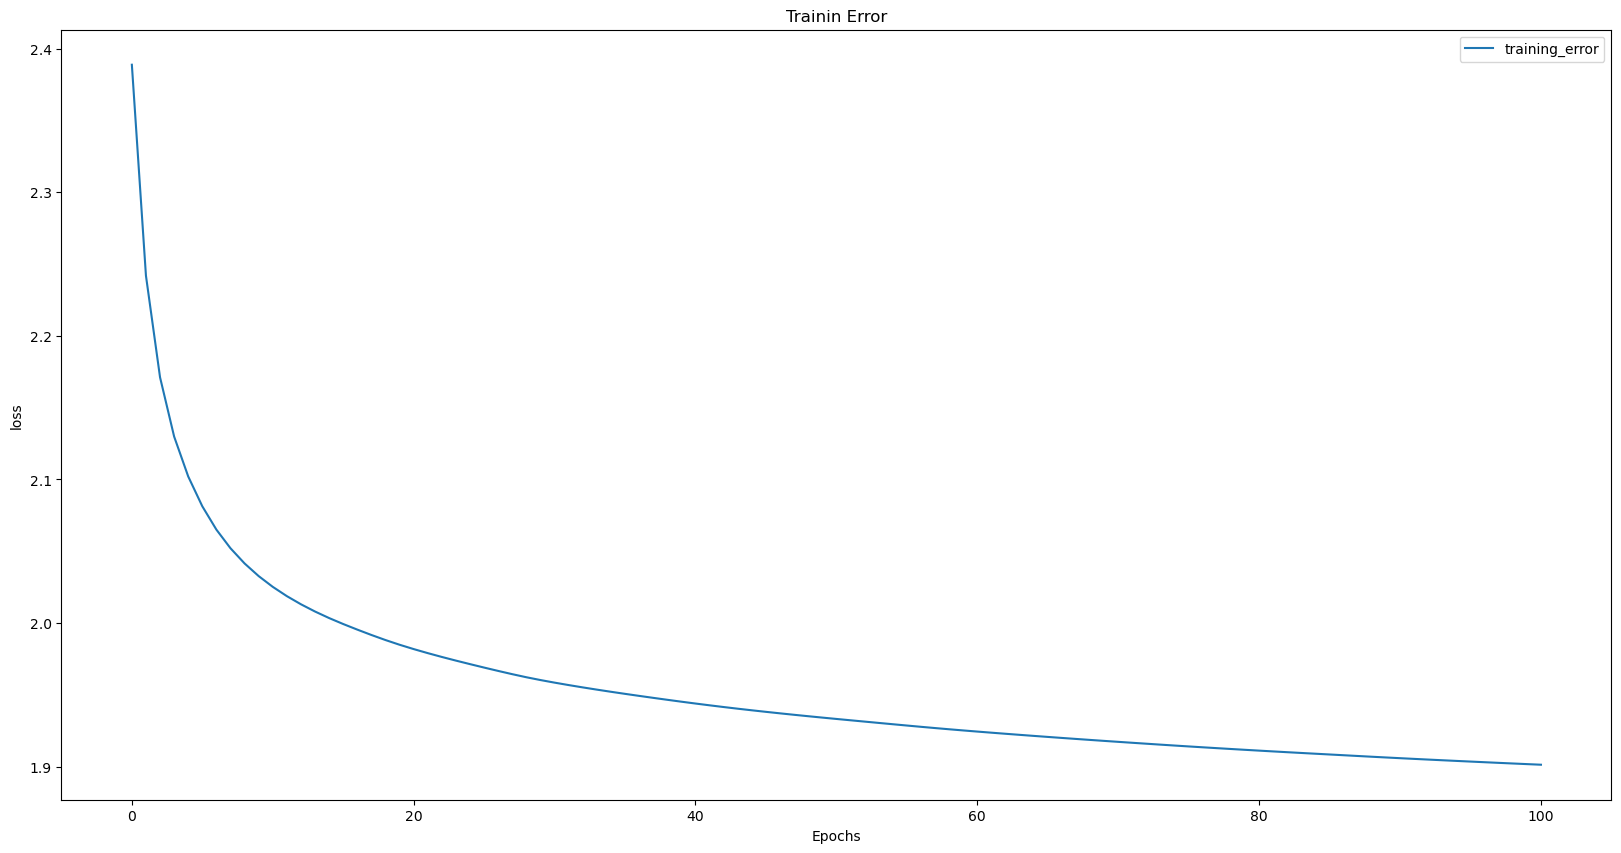

In [12]:
plt.rcParams['figure.figsize'] = [20, 10]
df = pd.read_csv('stats.csv')
df[['epoch', 'training_error']].plot(
    x='epoch',
    xlabel='Epochs',
    ylabel='loss',
    title='Trainin Error'
)
_=plt.show()

<b><h2>Loading BERT model</h2></b><br>
We chose to use the pretrained [BERT Miniatures](https://huggingface.co/google/bert_uncased_L-2_H-128_A-2) model.


In [8]:
bert = BertModel.from_pretrained('google/bert_uncased_L-2_H-128_A-2', cache_dir="cache", output_attentions=True,
                                                      output_hidden_states = False)

Some weights of the model checkpoint at google/bert_uncased_L-2_H-128_A-2 were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [9]:
l_tensor = np.diag(np.ones(n_label))

In [10]:
path = "nlp2022_23_data/thedeep.subset.{}.txt"
csv_header = ['idx', 'text', 'label']
for split in SPLITS:
        datasets[split] = {}
        datasets[split]['df'] = pd.read_csv(path.format(split), names = csv_header)

#----------        
max_length = 50
batch_size = 64
n_label = 12
device = torch.device("mps")

**<h2>BERT tokenization:</h2>**<br>
The tokenization has been done through the function `preprocess`, which takes the data as input: first the raw text is tokenized by the `BertTokenizer` (including the special tokens), then the documents gets trucated up to the `maxlen` set to 50, and if shorter a padding gets added. Finally a mask is created to distinguish actual id_token from padding.<br> It outputs three tensors, respectively:<br>
1. mask  <br>
2. IDS of processed data
3. labels


In [11]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [12]:
def preprocess(dataset):
    input_ids = []
    
    for doc in dataset["text"]:
        encoded_doc = tokenizer.encode(doc, add_special_tokens = True) 
        input_ids.append(encoded_doc)
        
    input_ids = pad_sequences(input_ids, maxlen=max_length, dtype="long",
                          value=0, truncating="post", padding="post")
    att_mask = []
    for doc in input_ids: 
        attention_mask = [int(token_id > 0) for token_id in doc]
        att_mask.append(attention_mask)
    
    return torch.tensor(att_mask), torch.tensor(input_ids), torch.tensor(dataset["label"])

In [13]:
mask_train, X_train, y_train = preprocess(datasets["train"]['df'])
mask_validation, X_validation, y_validation = preprocess(datasets["validation"]['df'])
mask_test, X_test, y_test = preprocess(datasets["test"]['df'])

Token indices sequence length is longer than the specified maximum sequence length for this model (876 > 512). Running this sequence through the model will result in indexing errors


In [14]:
#dataloader
train_data = TensorDataset(X_train, mask_train, y_train)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(X_validation, mask_validation, y_validation)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler,  batch_size=batch_size)

test_data = TensorDataset(X_test, mask_test, y_test)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

**<h2>Model definition and forward function:</h2>**<br> We define the class **`ClassificationBERTModel`** as a PyTorch model. <br> We basically used the same functin as in the first part of the notebook, the only difference is in the argument of the forward function: for each batch we pass both input data and mask (instead of only data). <br><b><BODY TEXT="#ff0000 ">Sadly due to computational and time limitation the kernel kept dying and we didn't manage to solve the rest of the assignment before deadline.</b>


In [15]:
class ClassificationBERTModel(torch.nn.Module):
    
    def __init__(self, bert, n_label):
        
        super(ClassificationBERTModel, self).__init__()

        self.model = bert
        self.transformation = torch.nn.Linear(in_features = bert.config.hidden_size, out_features = n_label)
        self.softmax = torch.nn.Softmax(dim=-1)
        
        
    
    def forward(self, x):
        
        res = self.model.forward(input_ids=x[0].to(device), attention_mask =x[1].to(device), token_type_ids=None)
        return self.softmax(self.transformation(res["last_hidden_state"]))
        
      
    

In [16]:
#@torch.enable_grad()
def update(dataloader, model, loss, optimizer, l_tensor): 
    device = next(model.parameters()).device
    err = []
    model.train()
    
    for x,z,y in dataloader:
      
        x, z, y = x.to(device), z.to(device), y.to(device) #gpu



        optimizer.zero_grad()
        y_pred = model.forward((x,z))
        
        y_true = torch.tensor([l_tensor[i] for i in y])

        loss_ = loss(y_pred, y_true) 
        
      
        err.append(loss_)
        
        loss_.backward()
        
        optimizer.step() 
        
        
    return err, model
       

In [17]:
#@torch.no_grad()
def evaluate(val_dataloader, model):
    device = next(model.parameters()).device
    accuracy = []
    
    for x,z, y in val_dataloader:
        x, z, y = x.to(device), z.to(device), y.to(device) #gpu
        
        y_pred = model.forward((x,z))
        y_pred = torch.argmax(y_pred, dim=1)
        accuracy_ = torch.mean((y == y_pred).float())
        
        accuracy.append(accuracy_)
    
    return accuracy
        

In [ ]:
torch.manual_seed(42)

model = ClassificationBERTModel(bert, n_label = n_label).to(device)

lr = 0.001
#-----------------

loss = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
epochs = 3
best_mean = 0.0
last_accuracy = 0
stats = pd.DataFrame(columns=["epoch", "training_error", "validation_accuracy"])
early_stopping = 20 #fix value
early_stopping_counter = 20 #counts

#-----------------

start = time.time()
for epoch in range(epochs):
    
    train_err, model = update(train_dataloader, model, loss, optimizer, l_tensor)
    train_err = ([x.tolist() for x in train_err])
    train_err = np.mean(train_err)
    accuracy = evaluate(val_loader, model)
    accuracy = ([x.tolist() for x in accuracy])
    accuracy = np.mean(accuracy)
    break
    
    if epoch % 10 == 0:
        end2 = time.time()
        print(f"epoch n: {epoch}  accuracy: {accuracy} training_error: {train_err} in {end2-start} seconds")
    
    stats.loc[len(stats)] = [epoch,train_err,accuracy]
    
    if accuracy > best_mean:
        best_mean = accuracy
        torch.save(model, "best_model.pkl")
    
    else: #early stopping
        if np.isclose(last_accuracy, accuracy):
            
            if early_stopping_counter == 0:
                break

            else:
                early_stopping_counter -= 1
        else:
            early_stopping_counter = early_stopping
                  
    
    last_accuracy = accuracy
    

end = time.time()  
print(end-start)
stats.to_csv("stats.csv", index= False)
   